# SFS simulation
fastDFE provides a {class}`~fastdfe.simulation.Simulation` module to generate an expected SFS under a specific DFE, and potentially demographic nuisance parameters. In fact, when inferring the DFE with fastDFE, the expected SFS is repeatedly simulated for different parameters to find the maximum likelihood estimates. Below, we illustrate how to use the simulation module to generate SFS data under a given DFE. To do this, we need to specify a neutral SFS ({attr}`~fastdfe.simulation.Simulation.sfs_neut`), which is informative on the population sample size, population mutation rate, the number of sites, and possibly demography. {func}`~fastdfe.simulation.Simulation.get_neutral_sfs` can be used to obtain a neutral SFS under a constant panmictic population. We also specify the DFE parameters and parametrization. By default, we assume not ancestral misidentification (`eps=0`) and mutation are assumed to be semi-dominant (`h=0.5`).

In [ ]:
library(fastdfe)

# load the fastdfe package
fd <- load_fastdfe()

In [1]:
setwd("/Users/au732936/PycharmProjects/fastDFE")
reticulate::use_condaenv("/Users/au732936/miniconda3/envs/dev-r-fastdfe", required = TRUE)
source("R/fastdfe.R")
fd <- load_fastdfe()
options(repr.plot.width = 7, repr.plot.height = 3)

In [2]:
# create simulation object by specifying neutral SFS and DFE
sim <- fd$Simulation(
    sfs_neut = fd$Simulation$get_neutral_sfs(n = 20, n_sites = 1e8, theta = 1e-4),
    params = list(S_d = -300, b = 0.3, p_b = 0, S_b = 1),
    model = fd$GammaExpParametrization()
)

Let's plot the DFE we are going to use for the simulation which is purely deleterious and follows a gamma distribution.

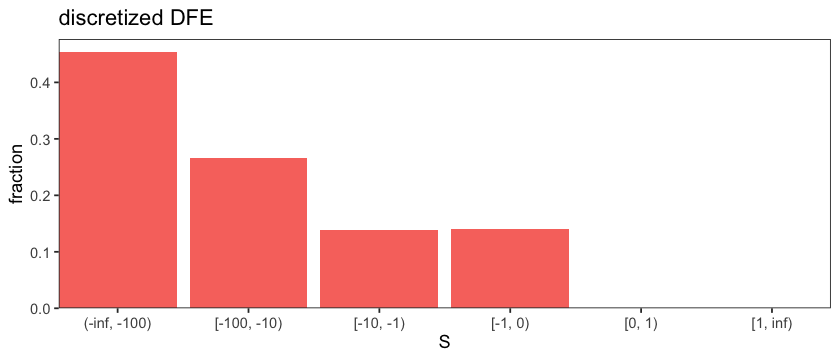

In [3]:
p <- sim$dfe$plot()

Let's now run the simulation and plot the expected SFS for both neutral (specified) and selected (simulated) sites.

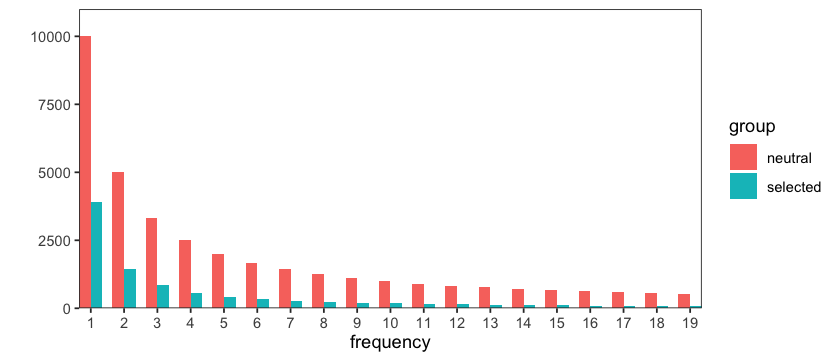

In [4]:
sfs_sel <- sim$run()
p <- sim$get_spectra()$plot()

We can now use the simulated SFS to infer the DFE parameters and assess how closely the inference recovers the true DFE used to generate the data.

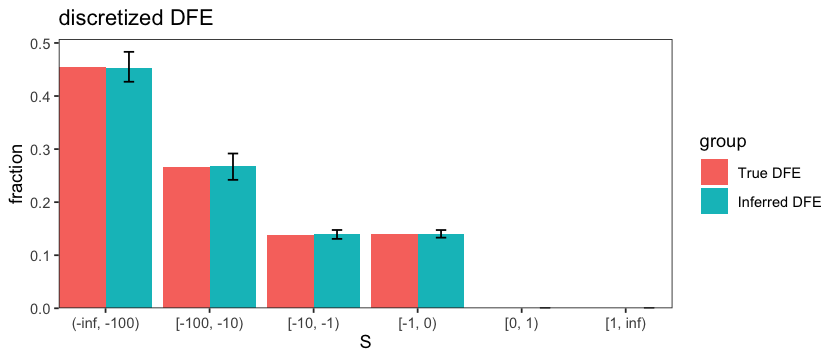

In [5]:
inf = fd$BaseInference(
    sfs_neut = sim$sfs_neut,
    sfs_sel = sim$sfs_sel,
    fixed_params = list(all = list(eps = 0, h = 0.5, p_b = 0, S_b = 1))
)

sfs_modelled <- inf$run()

p <- fd$DFE$plot_many(c(sim$dfe, inf$get_dfe()), labels = c('True DFE', 'Inferred DFE'))

The DFE is recovered quite well which is expected given the simplicity of the DFE parametrization and lack of demographic complications.

We may want to see how the expected SFS changes as we vary the degree of dominance. Here, we run a second simulation with the same parameters except that we set `h=0.3` so that mutations are partially recessive.

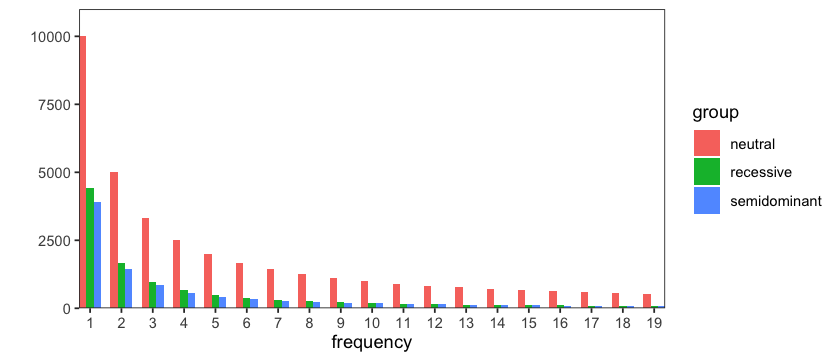

In [6]:
# run simulation with h=0.3
sim2 <- fd$Simulation(
    sfs_neut = fd$Simulation$get_neutral_sfs(n = 20, n_sites = 1e8, theta = 1e-4),
    params = list(S_d = -300, b = 0.3, p_b = 0, S_b = 1, h = 0.3),
    model = fd$GammaExpParametrization()
)

sfs_sel <- sim2$run()

p <- fd$Spectra$from_spectra(list(
    neutral = sim$sfs_neut,
    semidominant = sim$sfs_sel,
    recessive = sim2$sfs_sel
))$plot()

As expected, partially recessive mutations lead to an excess of rare variants because they are masked in heterozygotes and experience weaker purifying selection. At higher frequencies, the difference from the semidominant case diminishes as derived-allele homozygotes become more common.

We can now infer the DFE under the (incorrect) assumption that mutations are semidominant (`h=0.5`) and see how this affects the inference result.

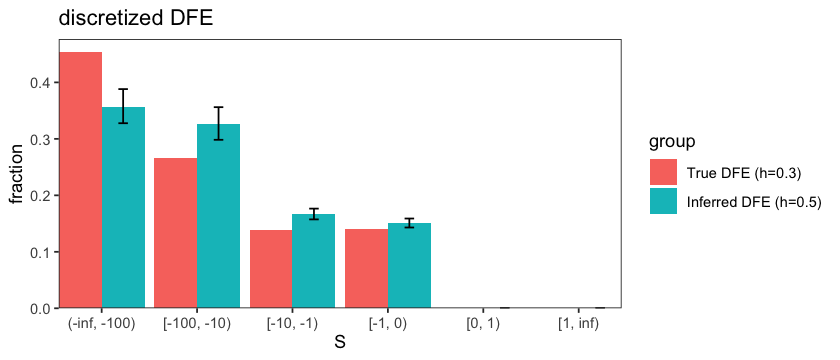

In [7]:
inf <- fd$BaseInference(
    sfs_neut = sim2$sfs_neut,
    sfs_sel = sim2$sfs_sel
)

sfs_modelled <- inf$run()

p <- fd$DFE$plot_many(c(sim2$dfe, inf$get_dfe()), labels = c('True DFE (h=0.3)', 'Inferred DFE (h=0.5)'))

Assuming semidominance when mutations are actually partially recessive leads to an inferred DFE shifted toward weaker selection coefficients. This happens because rare variants generated by recessive mutations are misattributed to weaker selection when the dominance reduction in purifying selection is not accounted for.

We can also try to infer the DFE while letting the dominance coefficient `h` vary during the optimization. To optimize `h`, it needs to be discretized; in this example we use the default grid of 21 points between 0 and 1, with intermediate values obtained by linear interpolation. All required values are precomputed before the optimization, but allowing `h` to vary increases the computational cost because the expected SFS must be simulated for each `h` in the grid. To speed up the precomputation step, we instruct {class}`~fastdfe.base_inference.BaseInference` to use a coarser DFE discretization grid than the default, which should be sufficient for most inference scenarios.

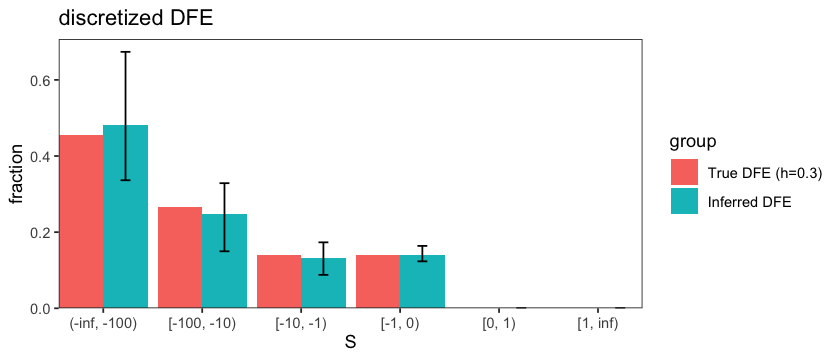

In [8]:
inf <- fd$BaseInference(
    sfs_neut = sim$sfs_neut,
    sfs_sel = sim$sfs_sel,
    intervals_h = c(0, 1, 21),
    intervals_del = c(-1.0e+8, -1.0e-5, 100),
    intervals_ben = c(1.0e-5, 1.0e4, 100),
    fixed_params = list(all = list(eps = 0, p_b = 0, S_b = 1))
)

sfs_modelled <- inf$run()

p <- fd$DFE$plot_many(c(sim2$dfe, inf$get_dfe()), labels = c('True DFE (h=0.3)', 'Inferred DFE'))

We see that allowing `h` to vary during inference roughly recovers the true DFE used for the simulation, but with substantially greater uncertainty. Finally, we can examine the bootstrap results to assess how well `h` was estimated.

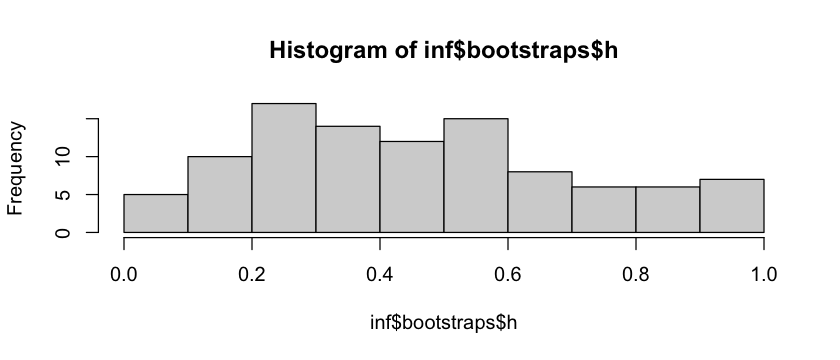

In [9]:
hist(inf$bootstraps$h)

We see that `h` was estimated with considerable uncertainty, but the bootstrap distribution still puts substantial mass near the true value `h = 0.3`. How well dominance can be inferred from SFS data alone remains an open question, especially when the DFE is more complex or additional nuisance parameters such as demography are included.

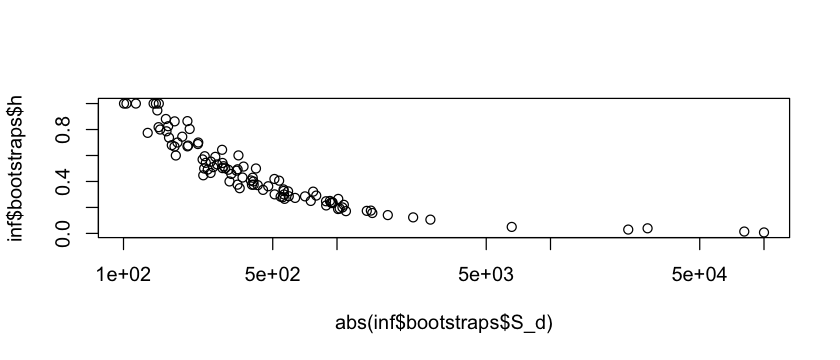

In [10]:
plot(abs(inf$bootstraps$S_d), inf$bootstraps$h, log="x")

Indeed, we see that `h` covaries with `S_d`, with larger `h` associated with less strongly deleterious mutations.